In [ ]:
!mkdir /root/.kaggle

In [ ]:
!cp kaggle.json /root/.kaggle/

In [ ]:
!kaggle datasets download daceik/foreximagesdata

Dataset URL: https://www.kaggle.com/datasets/daceik/foreximagesdata
License(s): CC0-1.0
 99% 734M/738M [00:10<00:00, 114MB/s]
100% 738M/738M [00:10<00:00, 72.0MB/s]


In [ ]:
!unzip foreximagesdata.zip

Streaming output truncated to the last 5000 lines.
  inflating: kaggle/tmp/data/zipped/ZARSEK_637.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_638.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_639.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_64.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_640.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_641.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_642.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_643.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_644.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_645.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_646.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_647.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_648.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_649.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_65.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_650.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_651.png  
  inflating: kaggle/tmp/data/zipped/ZARSEK_652.png

In [ ]:
!mv kaggle/tmp/data/zipped trend_images

In [ ]:
!ls trend_images | wc -l

1724951


In [ ]:
import os
import random
from tqdm import tqdm

import torch
from torch import nn
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
class EmbeddingGenerator:
  def __init__(self, num_images, batch_size):
    random.seed(4444)

    self.num_images = num_images
    self.batch_size = batch_size

    self.embeddings = torch.zeros((num_images, 4096)).to("cuda" if torch.cuda.is_available else "cpu")
    self.feature_extractor = vgg16(pretrained=True).features.requires_grad_(False)
    self.feature_extractor.to("cuda" if torch.cuda.is_available else "cpu")

    self.files = [os.path.join("trend_images", f) for f in os.listdir("trend_images")]
    self.files = random.choices(self.files, k=self.num_images)

    self.imagenet_mean = torch.Tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    self.imagenet_std = torch.Tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

  @torch.no_grad()
  def process_batch(self, batch):
    # batch represents a list of files.

    images  = []

    for f in batch:
      img = np.asarray(Image.open(f).convert("RGB"))
      img = torch.from_numpy(img).clone().permute(2, 0, 1)
      img = img / 255
      img = (img - self.imagenet_mean) / self.imagenet_std
      img = img.unsqueeze(0)
      images.append(img)

    images = torch.concatenate(images, 0)
    images = images.to("cuda" if torch.cuda.is_available else "cpu")

    embeddings = self.feature_extractor(images).view(images.shape[0], -1)

    return embeddings

  @torch.no_grad()
  def run(self):
    for i in tqdm(range(round(len(self.files) / self.batch_size + .5))):
      batch_of_files = self.files[(i*self.batch_size):(i*self.batch_size + self.batch_size)]
      batch_of_embeddings = self.process_batch(batch_of_files)
      self.embeddings[(i*self.batch_size):(i*self.batch_size + self.batch_size)] = batch_of_embeddings


In [ ]:
embedding_generator = EmbeddingGenerator(num_images=100000, batch_size=128)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 69.7MB/s]


In [ ]:
embedding_generator.run()

  0%|          | 0/782 [00:00<?, ?it/s]<ipython-input-8-29496a341e59>:26: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(img).clone().permute(2, 0, 1)
100%|██████████| 782/782 [02:05<00:00,  6.21it/s]


In [ ]:
embedding_generator.embeddings.shape

torch.Size([100000, 4096])

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.7 MB/s eta 0:00:00


In [ ]:
from umap import UMAP

In [ ]:
embedding_projected = UMAP().fit_transform(embedding_generator.embeddings.cpu().numpy())

In [ ]:
embedding_projected.shape

(100000, 2)

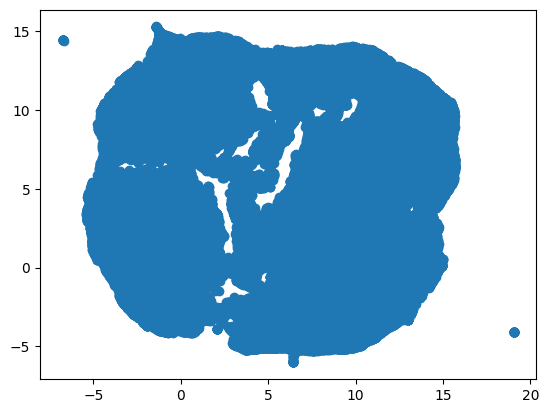

In [ ]:
plt.scatter(embedding_projected[:, 0], embedding_projected[:, 1])

In [ ]:
np.save("embedding_generator.files.npy", embedding_generator.files)

In [ ]:
np.save("umap_embedding_projection.npy", embedding_projected)

In [ ]:
np.save("embedding_generator.embeddings.npy", embedding_generator.embeddings.cpu().numpy())

In [ ]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.7 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [ ]:
import hdbscan

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=20)

In [ ]:
cluster_labels = clusterer.fit_predict(embedding_projected)

In [ ]:
cluster_labels.shape

(100000,)

In [ ]:
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

In [ ]:
n_clusters

3

In [ ]:
n_noise

1857

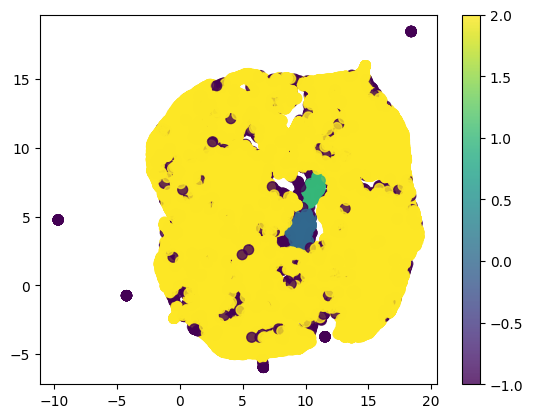

In [ ]:
plt.scatter(embedding_projected[:, 0], embedding_projected[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.8)
plt.colorbar()

In [ ]:
embedding_projected_normalised = (embedding_projected - embedding_projected.mean(axis=0)) / embedding_projected.std(axis=0)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


3 1806


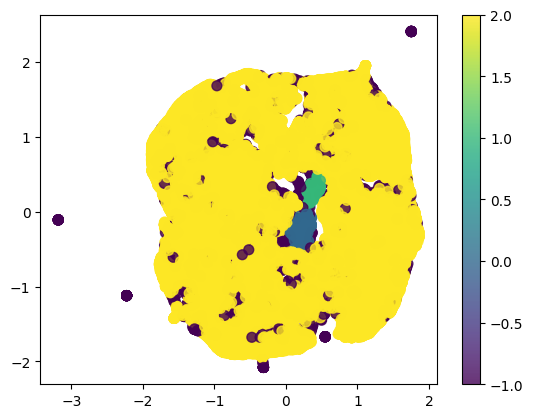

In [ ]:
clusterer_normalised = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=20)
cluster_normalised_labels = clusterer_normalised.fit_predict(embedding_projected_normalised)
n_clusters_normalised = len(set(cluster_normalised_labels)) - (1 if -1 in cluster_normalised_labels else 0)
n_noise_normalised = list(cluster_normalised_labels).count(-1)

print(n_clusters_normalised, n_noise_normalised)

plt.scatter(embedding_projected_normalised[:, 0], embedding_projected_normalised[:, 1], c=cluster_normalised_labels, cmap='viridis', s=50, alpha=0.8)
plt.colorbar()

In [ ]:
large_cluster = embedding_projected[cluster_labels==2]

In [ ]:
large_cluster.shape

(96361, 2)

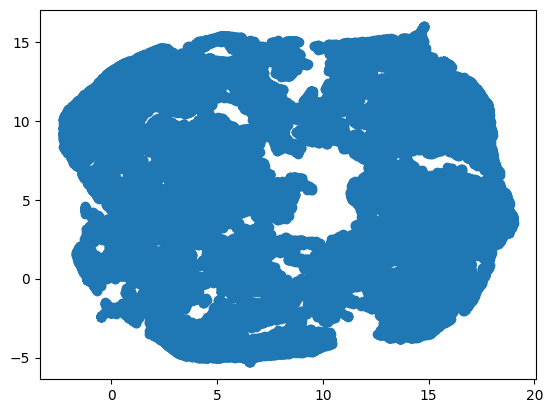

In [ ]:
plt.scatter(large_cluster[:, 0], large_cluster[:, 1])

2 550


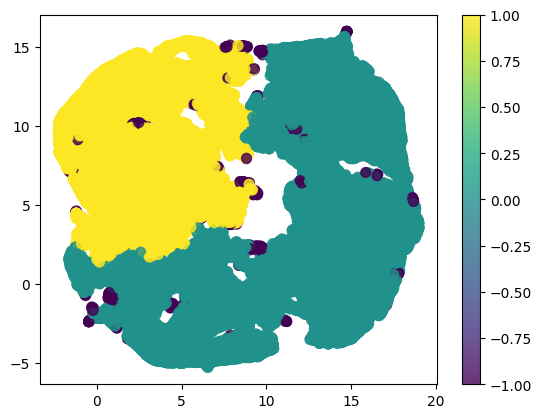

In [ ]:
clusterer_larger = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=100)
cluster_larger_labels = clusterer_larger.fit_predict(large_cluster)
n_clusters_larger = len(set(cluster_larger_labels)) - (1 if -1 in cluster_larger_labels else 0)
n_noise_larger = list(cluster_larger_labels).count(-1)

print(n_clusters_larger, n_noise_larger)

plt.scatter(large_cluster[:, 0], large_cluster[:, 1], c=cluster_larger_labels, cmap='viridis', s=50, alpha=0.8)
plt.colorbar()

In [ ]:
!kaggle datasets init -p trend_images

Data package template written to: trend_images/dataset-metadata.json


In [ ]:
!mkdir forex_vgg_embeds_exper

In [ ]:
!mv embedding_generator.embeddings.npy forex_vgg_embeds_exper/

In [ ]:
!mv embedding_generator.files.npy forex_vgg_embeds_exper

In [ ]:
!mv umap_embedding_projection.npy forex_vgg_embeds_exper

In [ ]:
!cp trend_images/dataset-metadata.json .

In [ ]:
!mv dataset-metadata.json forex_vgg_embeds_exper

In [ ]:
!kaggle datasets create -p forex_vgg_embeds_exper

Starting upload for file embedding_generator.files.npy
100% 10.7M/10.7M [00:00<00:00, 13.5MB/s]
Upload successful: embedding_generator.files.npy (11MB)
Starting upload for file umap_embedding_projection.npy
100% 781k/781k [00:00<00:00, 1.10MB/s]
Upload successful: umap_embedding_projection.npy (781KB)
Starting upload for file embedding_generator.embeddings.npy
100% 1.53G/1.53G [00:17<00:00, 94.3MB/s]
Upload successful: embedding_generator.embeddings.npy (2GB)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/daceik/forex-images-vgg-embeddings


In [ ]:
larger_larger_cluster = large_cluster[cluster_larger_labels == 0]

In [ ]:
larger_larger_cluster.shape

(61271, 2)

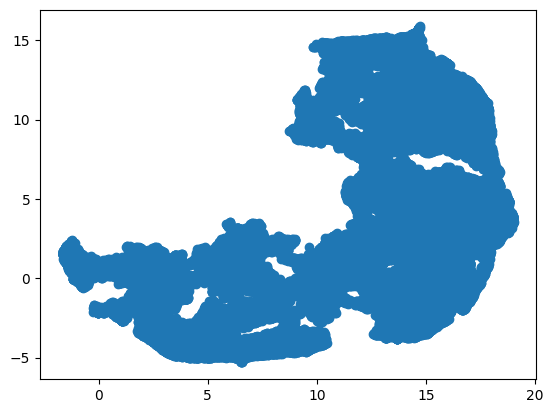

In [ ]:
plt.scatter(larger_larger_cluster[:, 0], larger_larger_cluster[:, 1])

In [ ]:
clusterer_larger_larger = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=100)
cluster_larger_larger_labels = clusterer_larger.fit_predict(larger_larger_cluster)
n_clusters_larger_larger = len(set(cluster_larger_larger_labels)) - (1 if -1 in cluster_larger_larger_labels else 0)
n_noise_larger_larger = list(cluster_larger_larger_labels).count(-1)

print(n_clusters_larger_larger, n_noise_larger_larger)

plt.scatter(larger_larger_cluster[:, 0], larger_larger_cluster[:, 1], c=cluster_larger_larger_labels, cmap='viridis', s=50, alpha=0.8)
plt.colorbar()